# **BCG X Capstone Project** 
<img src="https://web-assets.bcg.com/1a/1f/6b52570e4ba49920815bdda88e36/bcgx-meet-banner.jpg" alt="drawing" style="width:800px; height:300px"/>

### **Product Analysis & Cross-Selling Notebook**

**Group members**

Morten Aas-Lyngby, Paolo Brambillasca,  Ignacio Alonso Lopez-Linares, Emilio Jair Rodriguez Capitan, Alberto Dona

**Notebook description**

This notebook provides the third step in our Analysis. 
It focusses on captivating product cross-selling strategies, as well as calculating customer lifetime value and prioritising marketing actions.

**Problem definition**

The Team has been tasked with building a Churn Model to increase CLTV as well as to help ClienCo. in their product cross-selling strategy and demand forecasting problem.

# Table of Contents

1. [Importing Necessary Libraries](#1-importing-necessary-libraries)
2. [Dataset Loading](#2-dataset-loading)
3. [Product Segmentation, ABC Analysis](#3-product-segmentation-abc-analysis)
4. [Market Analysis - Association Rules](#4-market-analysis---association-rules)
   - [4.1 Preprocessing](#41-preprocessing)
   - [4.2 Sample Products](#42-sample-products)
   - [4.3 Sample Clients](#43-sample-clients)
   - [4.4 Apply Association Rules](#44-apply-association-rules)
5. [Cross-Selling](#5-cross-selling)
   - [5.1 Product Prices](#51-product-prices)
   - [5.2 Identifying Opportunities for Cross-Selling](#52-identifying-opportunities-for-cross-selling)
   - [5.3 Financial Impact of Cross-Selling](#53-financial-impact-of-cross-selling)
6. [Future Lines of Work](#6-future-lines-of-work)


### **1. Importing necessary Libraries**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import re

### **2. Dataset loading**

In [2]:
data = pd.read_parquet('data/transactions_cleaned')

In [3]:
data.drop(columns=['date_invoice', 'client_id', 'order_channel', 'branch_id'], inplace=True)
data = data[data['sales_net'] > 0]
data.head()

,date_order,product_id,sales_net,quantity,invoice_delay,sales_per_quantity,order_year,order_month,order_day_month,order_day_week,order_period,monthly_sales,previous_month_sales
0,2017-09-25,2376333,155.443207,3,0.0,51.814400,2017,September,25,Monday,2017-09,86852728.0,86852728.0
1,2017-09-25,2520527,16.394400,3,0.0,5.464800,2017,September,25,Monday,2017-09,86852728.0,86852728.0
2,2017-09-25,2536756,365.766235,21,0.0,17.417440,2017,September,25,Monday,2017-09,86852728.0,86852728.0
3,2017-09-25,3028673,8.598780,201,0.0,0.042780,2017,September,25,Monday,2017-09,86852728.0,86852728.0
4,2017-09-25,203377,1093.374023,3,0.0,364.458008,2017,September,25,Monday,2017-09,86852728.0,86852728.0


### **3. Product Segmentation, ABC Analysis**

To segment the products we devided them into three groups based on the cumulative sales:
 - 0 to 80 percent of sales -> Group A
 - 80 to 95 percent of sales -> Group B
 - 95 to 100 percent of sales -> Group C

In [12]:
products_grouped = data.groupby('product_id')[['sales_net','quantity']].sum().reset_index()


products_grouped = products_grouped.sort_values(by='sales_net', ascending=False)

products_grouped['cum_sales'] = products_grouped['sales_net'].cumsum()
products_grouped['cum_sales_percentage'] = products_grouped['cum_sales']/ products_grouped['sales_net'].sum() * 100
products_grouped['cum_product_percentage'] = np.arange(1, len(products_grouped) + 1) / len(products_grouped) * 100

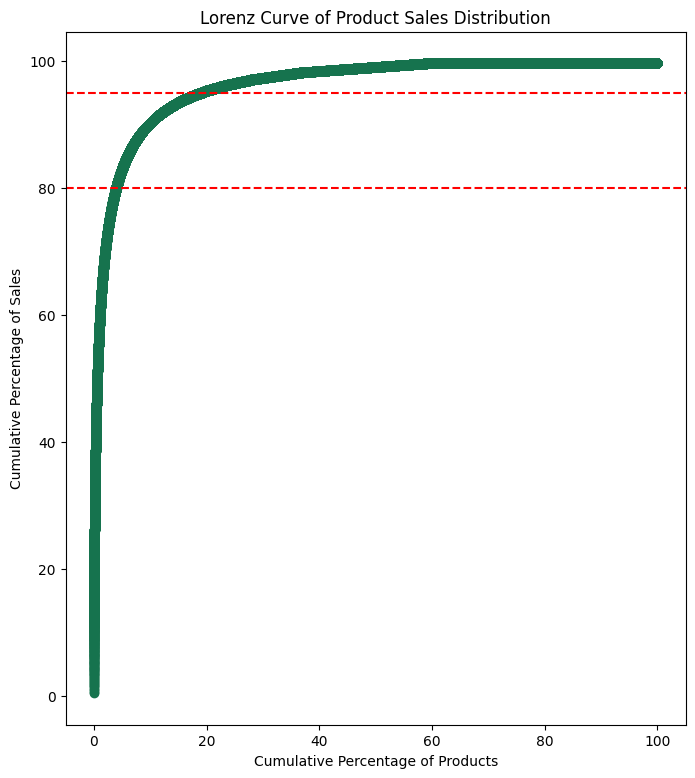

In [13]:
plt.figure(figsize=(8, 9))
plt.plot(products_grouped['cum_product_percentage'], products_grouped['cum_sales_percentage'], marker='o', linestyle='-', color='#16734e')
plt.xlabel('Cumulative Percentage of Products')
plt.axhline(80, color='r', linestyle='--', )
plt.axhline(95, color='r', linestyle='--', )
plt.ylabel('Cumulative Percentage of Sales')
plt.title('Lorenz Curve of Product Sales Distribution')
plt.show()

From the graph we see that a very small percentage of the products account for 80% of the sales and that a large amount of products only account for 5% of the sales. This is the reason for why we chose to segment the products on percentages 80 and 95.

In [14]:
# Find the percentage of products accounting for 80% and 90% of the sales
perc_80 = (products_grouped.loc[products_grouped['cum_sales_percentage'] >= 80, 'cum_product_percentage'].iloc[0])/100
perc_95 = (products_grouped.loc[products_grouped['cum_sales_percentage'] >= 95, 'cum_product_percentage'].iloc[0])/100


print(f"The percentage of products accounting for 80% of the sales is: {perc_80*100}%")
print(f"The percentage of products accounting for 95% of the sales is: {perc_95*100}%")

The percentage of products accounting for 80% of the sales is: 3.944185278454362%
The percentage of products accounting for 95% of the sales is: 18.866201543987117%


In [15]:
products_grouped.loc[products_grouped['cum_sales_percentage'] <= 80, 'ABC_group'] = 'A'
products_grouped.loc[(products_grouped['cum_sales_percentage'] > 80) & (products_grouped['cum_product_percentage'] <= 95), 'ABC_group'] = 'B'
products_grouped.loc[products_grouped['cum_sales_percentage'] > 95, 'ABC_group'] = 'C'

products_grouped.head()

,product_id,sales_net,quantity,cum_sales,cum_sales_percentage,cum_product_percentage,ABC_group
501253,2681878,39394264.0,77818327,39394264.0,0.404698,0.000165,A
86334,463156,24648122.0,72300233,64042384.0,0.657908,0.000330,A
475111,2542409,23929256.0,36982251,87971640.0,0.903734,0.000495,A
233910,1253061,23679756.0,492683,111651392.0,1.146996,0.000661,A
247463,1325810,19905242.0,46571760,131556632.0,1.351483,0.000826,A


In [16]:
abc = products_grouped['ABC_group'].value_counts().to_frame().reset_index()
abc.columns = ['ABC_group', 'n_Items']
abc

,ABC_group,n_Items
0,C,491327
1,B,90364
2,A,23884


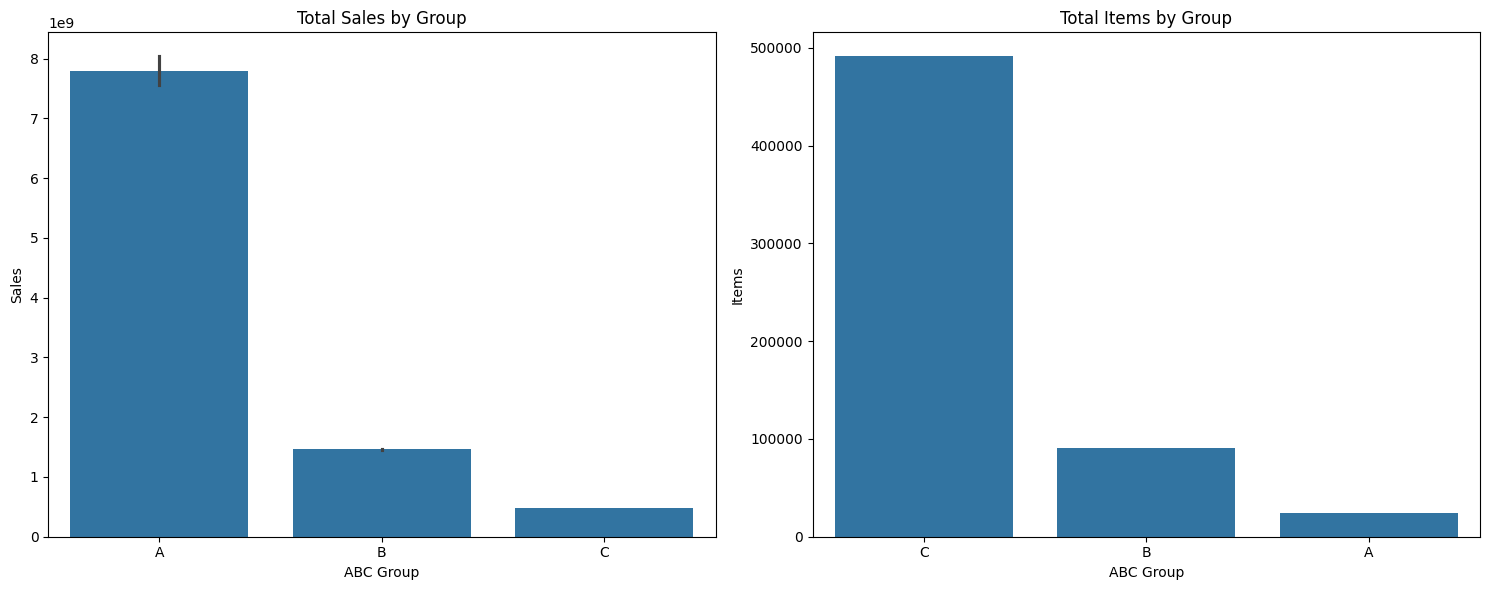

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=products_grouped, x='ABC_group', y='sales_net', estimator=sum, ax=axes[0])
axes[0].set_title('Total Sales by Group')
axes[0].set_xlabel('ABC Group')
axes[0].set_ylabel('Sales')

sns.barplot(data=abc, x='ABC_group', y='n_Items', ax=axes[1])
axes[1].set_title('Total Items by Group')
axes[1].set_xlabel('ABC Group')
axes[1].set_ylabel('Items')

plt.tight_layout()
plt.show()

In [18]:
products_grouped.to_parquet('data/products_grouped_ABC.parquet')

### **4. Market Analysis - Association Rules**

Steps taken to create association rules:

- Downsampling: The plan was to do the basket analysis on the transactions of product in group A.after trying and failing with RAM-limitation on the association rules we ended up the top 50 products and the top 100 clients based on total sales. This gave 8 604 transactions, which was small enough to calculate the association rules.

- To create the association rules we created a column for each transaction. We made an assumpion that a client will only make one purchase per day. All purchases within a day per customer is one transaction.

- We then pivoted the table to have the transactions (per customer per day) as rows and the products as columns.

- With the pivoted table we could then calculate the association rules.


Reference: Market Basket Analysis in Python

Source: https://365datascience.com/tutorials/python-tutorials/market-basket-analysis/

In [19]:
abc = pd.read_parquet('data/products_grouped_ABC.parquet')

In [20]:
transactions = pd.read_parquet('data/transactions_cleaned')

#### 4.1 Preprocessing

In [21]:
transactions = transactions.merge(abc[['product_id', 'ABC_group']], on='product_id', how='left')

In [22]:
transactions.drop(columns=['invoice_delay', 'sales_per_quantity', 'order_year', 
                           'order_month', 'order_day_month', 'order_day_week', 
                           'order_period', 'monthly_sales', 'previous_month_sales'], inplace=True)

In [23]:
transactions.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,ABC_group
0,2017-09-25,2017-09-25,2376333,188502,155.443207,3,online,2732,A
1,2017-09-25,2017-09-25,2520527,835089,16.394400,3,at the store,10279,A
2,2017-09-25,2017-09-25,2536756,1977896,365.766235,21,online,6184,A
3,2017-09-25,2017-09-25,3028673,598816,8.598780,201,at the store,4200,A
4,2017-09-25,2017-09-25,203377,2086861,1093.374023,3,by phone,7051,A


In [24]:
trans_A = transactions[transactions['ABC_group'] == 'A']
trans_A = trans_A[trans_A['sales_net']>0]
trans_A['ABC_group'].value_counts()

ABC_group
A    47493208
Name: count, dtype: int64

#### 4.2 Sample Products

In [25]:
products = abc[['product_id', 'cum_sales_percentage']].sort_values(by=['cum_sales_percentage']).head(50)

In [26]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 501253 to 11549
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            50 non-null     int32  
 1   cum_sales_percentage  50 non-null     float32
dtypes: float32(1), int32(1)
memory usage: 800.0 bytes


In [27]:
trans_sample = trans_A[trans_A['product_id'].isin(products['product_id'])]

#### 4.3 Sample Clients

In [28]:
trans_A.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,ABC_group
0,2017-09-25,2017-09-25,2376333,188502,155.443207,3,online,2732,A
1,2017-09-25,2017-09-25,2520527,835089,16.394400,3,at the store,10279,A
2,2017-09-25,2017-09-25,2536756,1977896,365.766235,21,online,6184,A
3,2017-09-25,2017-09-25,3028673,598816,8.598780,201,at the store,4200,A
4,2017-09-25,2017-09-25,203377,2086861,1093.374023,3,by phone,7051,A


In [29]:
trans_A.drop(columns=['date_invoice', 'product_id','quantity', 'order_channel', 'branch_id'], inplace=True)

In [30]:
clients = trans_A.groupby(['client_id', 'date_order'])[['sales_net']].sum().reset_index()
clients.head()

,client_id,date_order,sales_net
0,6,2017-10-27,1358.089844
1,6,2017-11-29,204.129608
2,6,2018-03-30,462.551697
3,6,2018-05-10,565.054260
4,6,2018-11-20,270.802002


In [31]:
 clients = clients.sort_values(by=['sales_net'], ascending=False).head(100)

In [32]:
trans_sample = trans_sample[trans_sample['client_id'].isin(clients['client_id'])]

In [33]:
trans_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8668 entries, 6362 to 61739269
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date_order     8668 non-null   datetime64[ns]
 1   date_invoice   8668 non-null   datetime64[ns]
 2   product_id     8668 non-null   int32         
 3   client_id      8668 non-null   int32         
 4   sales_net      8668 non-null   float32       
 5   quantity       8668 non-null   int32         
 6   order_channel  8668 non-null   category      
 7   branch_id      8668 non-null   int16         
 8   ABC_group      8668 non-null   object        
dtypes: category(1), datetime64[ns](2), float32(1), int16(1), int32(3), object(1)
memory usage: 431.9+ KB


In [34]:
trans_sample.to_parquet('data/trans_sample.parquet')

#### 4.4 Apply Association Rules

In [35]:
trans_sample.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,ABC_group
6362,2017-10-02,2017-10-03,2734140,1552980,22.107599,9,online,1525,A
7291,2017-09-25,2017-09-25,2354998,1666266,52.699017,27,at the store,5261,A
7491,2017-09-25,2017-09-25,1745137,1666266,87.721428,33,at the store,5261,A
8241,2017-09-25,2017-09-25,2542409,1666266,92.275078,201,at the store,5261,A
13090,2017-09-29,2017-09-29,2542409,1666266,89.279373,201,at the store,5261,A


In [36]:
#To clear dataframes from memory that will not be used further.
import gc
del abc
del transactions
del trans_A

gc.collect()

9725

In [37]:
trans_sample.drop(columns=['ABC_group', 'date_invoice', 'sales_net', 'quantity', 'order_channel', 'branch_id'], inplace=True)

trans_sample['single_transaction'] = trans_sample['client_id'].astype(str)+'_'+trans_sample['date_order'].astype(str)
trans_sample.head()

,date_order,product_id,client_id,single_transaction
6362,2017-10-02,2734140,1552980,1552980_2017-10-02
7291,2017-09-25,2354998,1666266,1666266_2017-09-25
7491,2017-09-25,1745137,1666266,1666266_2017-09-25
8241,2017-09-25,2542409,1666266,1666266_2017-09-25
13090,2017-09-29,2542409,1666266,1666266_2017-09-29


In [38]:
sample_pivot = pd.crosstab(trans_sample['single_transaction'], trans_sample['product_id'])
sample_pivot.head()

product_id,11100,59473,85044,246256,378845,417321,463156,517859,547877,560204,...,2198494,2354998,2542409,2564840,2681878,2732769,2734140,2995747,3122216,3152916
single_transaction,,,,,,,,,,,,,,,,,,,,,
1002324_2017-11-16,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1061432_2018-03-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1080520_2017-09-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1080520_2017-09-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1080520_2017-09-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [39]:
#Some customers bought the same product more than once in the same day. We still count this as one purchase and need to encode these to 1.
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res

basket_input = sample_pivot.applymap(encode)

C:\Users\Inas\AppData\Local\Temp\ipykernel_24572\481825376.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_input = sample_pivot.applymap(encode)


In [40]:
frequent_itemsets = apriori(basket_input, min_support=0.001, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift")

rules.head()

c:\Users\Inas\anaconda3\envs\capstone\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(11100),(85044),0.024187,0.013344,0.002502,0.103448,7.752155,0.002179,1.100500,0.892593
1,(85044),(11100),0.013344,0.024187,0.002502,0.187500,7.752155,0.002179,1.201001,0.882784
2,(246256),(11100),0.015013,0.024187,0.002502,0.166667,6.890805,0.002139,1.170976,0.867909
3,(11100),(246256),0.024187,0.015013,0.002502,0.103448,6.890805,0.002139,1.098640,0.876068
4,(11100),(378845),0.024187,0.057131,0.002085,0.086207,1.508935,0.000703,1.031819,0.345641


In [41]:
rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(8)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1025,(2734140),(1390401),0.237698,0.316097,0.164304,0.691228,2.186761,0.089168,2.214914,0.711926
1024,(1390401),(2734140),0.316097,0.237698,0.164304,0.519789,2.186761,0.089168,1.587431,0.793537
342,(463156),(2681878),0.106339,0.129274,0.071726,0.674510,5.217660,0.057980,2.675121,0.904530
343,(2681878),(463156),0.129274,0.106339,0.071726,0.554839,5.217660,0.057980,2.007500,0.928356
1013,(2198494),(1390401),0.155963,0.316097,0.066722,0.427807,1.353407,0.017423,1.195233,0.309375
1012,(1390401),(2198494),0.316097,0.155963,0.066722,0.211082,1.353407,0.017423,1.069866,0.381814
1015,(2354998),(1390401),0.085071,0.316097,0.065054,0.764706,2.419215,0.038164,2.906589,0.641189
1014,(1390401),(2354998),0.316097,0.085071,0.065054,0.205805,2.419215,0.038164,1.152020,0.857786


In [43]:
rules.to_csv('data/rules.csv')

### **5. Cross-Selling**

#### 5.1 Product Prices


To know which products we want prioritize we need need the product prices.

In [50]:
prices = pd.read_parquet('data/transactions_cleaned')

In [51]:
prices.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,invoice_delay,sales_per_quantity,order_year,order_month,order_day_month,order_day_week,order_period,monthly_sales,previous_month_sales
0,2017-09-25,2017-09-25,2376333,188502,155.443207,3,online,2732,0.0,51.814400,2017,September,25,Monday,2017-09,86852728.0,86852728.0
1,2017-09-25,2017-09-25,2520527,835089,16.394400,3,at the store,10279,0.0,5.464800,2017,September,25,Monday,2017-09,86852728.0,86852728.0
2,2017-09-25,2017-09-25,2536756,1977896,365.766235,21,online,6184,0.0,17.417440,2017,September,25,Monday,2017-09,86852728.0,86852728.0
3,2017-09-25,2017-09-25,3028673,598816,8.598780,201,at the store,4200,0.0,0.042780,2017,September,25,Monday,2017-09,86852728.0,86852728.0
4,2017-09-25,2017-09-25,203377,2086861,1093.374023,3,by phone,7051,0.0,364.458008,2017,September,25,Monday,2017-09,86852728.0,86852728.0


In [52]:
prices.drop(columns=['date_order','date_invoice', 'client_id', 'order_channel', 'branch_id',
                     'invoice_delay', 'sales_per_quantity', 'order_year', 'order_month', 'order_day_month', 
                     'order_day_week', 'order_period', 'monthly_sales', 'previous_month_sales'], inplace=True)

In [54]:
prices = prices[prices['sales_net']>0]
prices.head()

,product_id,sales_net,quantity
0,2376333,155.443207,3
1,2520527,16.394400,3
2,2536756,365.766235,21
3,3028673,8.598780,201
4,203377,1093.374023,3


In [55]:
prices['price'] = prices['sales_net']/prices['quantity']

In [56]:
prices.drop(columns=['sales_net', 'quantity'], inplace=True)
prices.head()

,product_id,price
0,2376333,51.814402
1,2520527,5.464800
2,2536756,17.417440
3,3028673,0.042780
4,203377,364.458008


In [57]:
product_prices = prices.groupby('product_id')[['price']].mean().reset_index()
product_prices.head()

,product_id,price
0,15,0.213415
1,23,25.354433
2,28,2657.898405
3,39,4.811600
4,42,260.783203


In [58]:
product_prices.to_csv('data/product_prices.csv')

#### 5.2 Identifying Opportunities for Cross-selling

To identify the opportunities for cross-selling we create some rules based on support, lift and confidence for the products and for the rules.

The rules we made are the following:
- Confidence > 0.5: This is because we only want to recommend products that there is a reasonable chance the customer might want.
- Lift > 1.2: The reason for similar to the first. This is an indication that given the antecedent there is an increased chance the customer will want the consequent.
- Consequent support < 0.2: This is because we don't want to suggest the most products that are too common. This is because the client most likely would have chosen the product if they wanted it. The point of the cross-selling is to recommend products that the customer might want, but have not thought of.
- The products are all from segment A, and it is only the 50 products with the highest sales. From this we deducted that none of the product will be too niche.


To put a monetary value on the cross-selling we created a column called expected value. The expected value is the price of the consequent multiplied with the confidence of the rule. The rationale behind this is that since confidence measures the likelihood that item B is purchased when item A is purchased, we assume that suggesting the consequent will be successful at the same rate as the confidence. This is of course a simplification, but it serves as a estimate.

In [59]:
rules = pd.read_csv('data/rules.csv')
product_prices = pd.read_csv('data/product_prices.csv')

In [60]:
rules.head()

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,0,frozenset({11100}),frozenset({85044}),0.024187,0.013344,0.002502,0.103448,7.752155,0.002179,1.100500,0.892593
1,1,frozenset({85044}),frozenset({11100}),0.013344,0.024187,0.002502,0.187500,7.752155,0.002179,1.201001,0.882784
2,2,frozenset({246256}),frozenset({11100}),0.015013,0.024187,0.002502,0.166667,6.890805,0.002139,1.170976,0.867909
3,3,frozenset({11100}),frozenset({246256}),0.024187,0.015013,0.002502,0.103448,6.890805,0.002139,1.098640,0.876068
4,4,frozenset({11100}),frozenset({378845}),0.024187,0.057131,0.002085,0.086207,1.508935,0.000703,1.031819,0.345641


In [61]:
#The antecedents and consequents stored in frozen sets. We need to extract the numbers.
def extract_number(s):
    return re.findall(r'\d+', s)[0]

rules['antecedents'] = rules['antecedents'].apply(extract_number)
rules['consequents'] = rules['consequents'].apply(extract_number)


In [62]:
#We have to convert the antecedents and consequents to integers to merge them with the prices.
rules['antecedents'] = rules['antecedents'].astype(int)
rules['consequents'] = rules['consequents'].astype(int)

rules = rules.merge(product_prices, left_on='antecedents', right_on='product_id', how='left').rename(columns={'price': 'antecedent_price'})
rules = rules.merge(product_prices, left_on='consequents', right_on='product_id', how='left').rename(columns={'price': 'consequent_price'})
rules.head()

,Unnamed: 0_x,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,Unnamed: 0_y,product_id_x,antecedent_price,Unnamed: 0,product_id_y,consequent_price
0,0,11100,85044,0.024187,0.013344,0.002502,0.103448,7.752155,0.002179,1.100500,0.892593,2009,11100,128.066813,15733,85044,114.956422
1,1,85044,11100,0.013344,0.024187,0.002502,0.187500,7.752155,0.002179,1.201001,0.882784,15733,85044,114.956422,2009,11100,128.066813
2,2,246256,11100,0.015013,0.024187,0.002502,0.166667,6.890805,0.002139,1.170976,0.867909,45736,246256,92.974555,2009,11100,128.066813
3,3,11100,246256,0.024187,0.015013,0.002502,0.103448,6.890805,0.002139,1.098640,0.876068,2009,11100,128.066813,45736,246256,92.974555
4,4,11100,378845,0.024187,0.057131,0.002085,0.086207,1.508935,0.000703,1.031819,0.345641,2009,11100,128.066813,70602,378845,1.752879


In [63]:
rules.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'product_id_x', 'product_id_y', 'Unnamed: 0'], inplace=True)

In [64]:
# Identify cross-sell opportunities based on confidence and lift
rules['is_cross_sell'] = (
    (rules['confidence'] > 0.5) &
    (rules['lift'] > 1.2) &
    (rules['consequent support'] < 0.2))


# Filter for cross-sell opportunities
cross_sell_opportunities = rules[rules['is_cross_sell']]
cross_sell_opportunities['expected_return'] = cross_sell_opportunities['consequent_price'] * cross_sell_opportunities['confidence']

cross_sell_opportunities = cross_sell_opportunities.sort_values(by='expected_return', ascending=False)

cross_sell_opportunities.head()


C:\Users\Inas\AppData\Local\Temp\ipykernel_24572\3096664025.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sell_opportunities['expected_return'] = cross_sell_opportunities['consequent_price'] * cross_sell_opportunities['confidence']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_price,consequent_price,is_cross_sell,expected_return
32458,1390401,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.997061,157.245503,True,117.934128
102304,1390401,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.997061,157.245503,True,117.934128
28014,915256,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.570204,157.245503,True,117.934128
57096,915256,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.570204,157.245503,True,117.934128
1971,59473,85044,0.001251,0.013344,0.001251,1.00,74.9375,0.001234,inf,0.987891,136.885747,114.956422,True,114.956422


In [65]:
cross_sell_opportunities.to_csv('data/cross_sell_opportunities.csv')

Improvements:
- Differences between customer segments
- Differences between order channels


#### 5.3 Finacial Impact of Cross-Selling


When we have the cross-selling opportunities and the expected return, we can make an estimation of what the financial impact will be from implementing a system for cross-selling.

To do this we found for each product, the consequent with the highest expected return, which is the product we want to suggest.

We then checked for a each product in each transaction (items purchased by a client within the same day) in the sampled transactions if the suggested consequent was in the basket. If the consequent was not in the basket we then increased the revenue with the expected return. Note: For this part we utilized ChatGPT.

For each product we only check if the consequent with the highest expected return is in the transaction. This means that the client could have bought a substitute for the consequent. Since we do not have more information about the product we made an assumption that the customer did not buy a substitute product.

In [66]:
data = pd.read_csv('data/cross_sell_opportunities.csv')

In [67]:
trans_sample = pd.read_parquet('data/trans_sample.parquet')

In [68]:
data.head()

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_price,consequent_price,is_cross_sell,expected_return
0,32458,1390401,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.997061,157.245503,True,117.934128
1,102304,1390401,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.997061,157.245503,True,117.934128
2,28014,915256,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.570204,157.245503,True,117.934128
3,57096,915256,579087,0.001668,0.012510,0.001251,0.75,59.9500,0.001230,3.949958,0.984962,0.570204,157.245503,True,117.934128
4,1971,59473,85044,0.001251,0.013344,0.001251,1.00,74.9375,0.001234,inf,0.987891,136.885747,114.956422,True,114.956422


In [69]:
data = data[['antecedents', 'consequents', 'expected_return']]
data.head()

,antecedents,consequents,expected_return
0,1390401,579087,117.934128
1,1390401,579087,117.934128
2,915256,579087,117.934128
3,915256,579087,117.934128
4,59473,85044,114.956422


In [70]:
max_return = data.groupby('antecedents')['expected_return'].idxmax().reset_index(drop=True)

data_max_return = data.loc[max_return]
data_max_return.head()

,antecedents,consequents,expected_return
61,11100,85044,68.973853
4,59473,85044,114.956422
25,85044,59473,82.131448
900,246256,2008648,33.689696
2645,378845,642862,8.858056


In [71]:
trans_sample.drop(columns=['date_invoice', 'order_channel', 'quantity', 'branch_id', 'ABC_group'], inplace=True)
trans_sample.head()

,date_order,product_id,client_id,sales_net
6362,2017-10-02,2734140,1552980,22.107599
7291,2017-09-25,2354998,1666266,52.699017
7491,2017-09-25,1745137,1666266,87.721428
8241,2017-09-25,2542409,1666266,92.275078
13090,2017-09-29,2542409,1666266,89.279373


In [72]:
trans_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8668 entries, 6362 to 61739269
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_order  8668 non-null   datetime64[ns]
 1   product_id  8668 non-null   int32         
 2   client_id   8668 non-null   int32         
 3   sales_net   8668 non-null   float32       
dtypes: datetime64[ns](1), float32(1), int32(2)
memory usage: 237.0 KB


In [73]:
trans_grouped = trans_sample.groupby(['client_id', 'date_order'])

In [74]:
#NOTE: To generate this code we utilized ChatGPT, and only made some small adjustments to the names


revenue_increase_list = []

# Iterate over each antecedent-consequent pair in the highest_return_data
for index, row in data_max_return.iterrows():
    antecedent = row['antecedents']
    consequent = row['consequents']
    expected_return = row['expected_return']

    # Initialize potential revenue increase
    potential_revenue_increase = 0

    # Iterate over each group
    for name, group in trans_grouped:
        # Check if the antecedent is in the product_id column and the consequent is not
        if antecedent in group['product_id'].values and consequent not in group['product_id'].values:
            potential_revenue_increase += expected_return

    # Append result to list
    revenue_increase_list.append((antecedent, consequent, potential_revenue_increase))

# Convert the result to a DataFrame for better readability
revenue_increase_df = pd.DataFrame(revenue_increase_list, columns=['antecedent', 'consequent', 'potential_revenue_increase'])

revenue_increase_df.head()

,antecedent,consequent,potential_revenue_increase
0,11100.0,85044.0,3586.640368
1,59473.0,85044.0,2529.041285
2,85044.0,59473.0,1724.760415
3,246256.0,2008648.0,1044.380586
4,378845.0,642862.0,1089.540901


In [75]:
potential_sales = revenue_increase_df['potential_revenue_increase'].sum()
sales = trans_sample['sales_net'].sum()
sales_impact = potential_sales/sales
print(f"The potential increase in sales for the sample is {potential_sales}%")
print(f"The ordanary sales for the sample is {sales}%")
print(f"The increase in sales is {sales_impact*100}%")


The potential increase in sales for the sample is 425736.643780148%
The ordanary sales for the sample is 5410123.0%
The increase in sales is 7.869259973944179%


In this example the sales net would increase with 2.4%. We do not have a good reference of what one might expect, but this does seems like a reasonable number.

### **6. Future Lines of Work** 



This approach gives a good insight into the value of effective cross-selling. To implement this in production this workflow for recommending products should be done for all the products in segment A. This is only 23 thousand products, so it should be possible with a powerfull infrastructure.

We only used the transactions from 100 clients based on sales. These clients are the big spenders and will probably not be a good representation of the whole customerbase.

An approach based on taking the customer segments and sales channels into account could give accurate recommendations.